In [1]:
import tensorflow as tf
print(tf.__version__)

2.13.0


In [2]:
# import tensorflow as tf
gpu_available = tf.test.is_gpu_available()
is_cuda_gpu_available = tf.test.is_gpu_available(cuda_only=True)
is_cuda_gpu_min_3 = tf.test.is_gpu_available(True, (3,0))

print(is_cuda_gpu_available)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
False


In [3]:
pip install Keras-Preprocessing

Note: you may need to restart the kernel to use updated packages.


In [4]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import itertools
import random

# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix

In [5]:
# import wget
# wget.download("https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py")

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

In [8]:
# !unzip non_smokers.zip -d non_smokers

In [9]:
# !unzip smokers.zip -d smokers

In [ ]:
import cv2
import glob
import numpy as np

smoking_data = []
# counter = 0
files = glob.glob ("smokers/*.jpg")
for myFile in files:
  # if counter > 2:
  #   break
  # print(myFile)
  image = cv2.imread(myFile)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  smoking_data.append (image)
  print('smoking_data shape:', np.array(smoking_data).shape)
#   counter = counter + 1

smoking_data = np.asarray(smoking_data)
print(smoking_data.shape)

In [11]:
smoking_data[0].shape

(250, 250, 3)

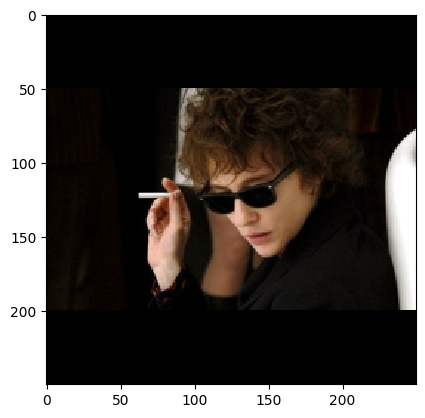

In [12]:
from matplotlib import pyplot as plt
plt.imshow(smoking_data[301], interpolation='nearest')
plt.show()

In [ ]:
import cv2
import glob
import numpy as np

not_smoking_data = []
# counter = 0
files = glob.glob ("non_smokers/*.jpg")
for myFile in files:
  # if counter > 2:
  #   break
  print(myFile)
  image = cv2.imread(myFile)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  not_smoking_data.append (image)
  print('not_smoking_data shape:', np.array(not_smoking_data).shape)
#   counter = counter + 1

not_smoking_data = np.asarray(not_smoking_data)
print(not_smoking_data.shape)

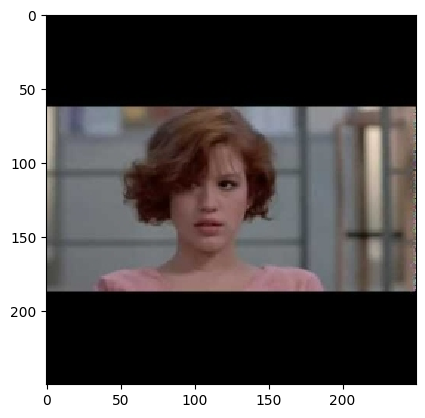

In [14]:
from matplotlib import pyplot as plt
plt.imshow(not_smoking_data[0], interpolation='nearest')
plt.show()

In [15]:
smoking_data[0].shape

(250, 250, 3)

In [16]:
# Data not normalized
print(smoking_data[smoking_data>254])
print(not_smoking_data[not_smoking_data>254])

[255 255 255 ... 255 255 255]
[255 255 255 ... 255 255 255]


In [17]:
# Data normalization
smoking_data, not_smoking_data = smoking_data / 255.0, not_smoking_data / 255.0
# Check data normalized
print(not_smoking_data[not_smoking_data>=1])

[1. 1. 1. ... 1. 1. 1.]


In [18]:
# Making Labels
smoking = 1
not_smoking = 0

smoking_labels = np.zeros(smoking_data.shape[0], dtype=np.int32)
not_smoking_labels = np.ones(not_smoking_data.shape[0], dtype=np.int32)

all_labels = np.concatenate((smoking_labels, not_smoking_labels))

all_labels_categorical = tf.keras.utils.to_categorical(all_labels, num_classes=2)

In [19]:
print (all_labels.shape)
# print (all_labels[3274])
print (all_labels_categorical[1997])
print (all_labels_categorical.shape)

(3275,)
[0. 1.]
(3275, 2)


In [20]:
all_labels_categorical.shape

(3275, 2)

In [21]:
# STACK ALL DATA TOGETHER
all_input_data = np.vstack((smoking_data,not_smoking_data))
all_input_data.shape

(3275, 250, 250, 3)

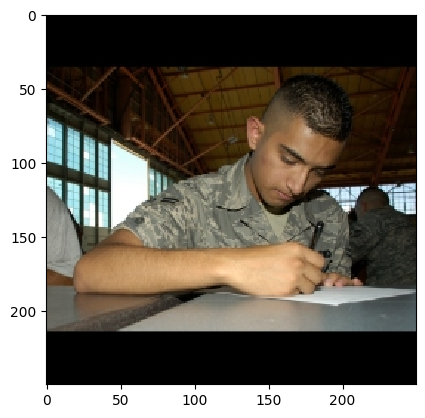

In [22]:
from matplotlib import pyplot as plt
plt.imshow(all_input_data[3274], interpolation='nearest')
plt.show()

In [23]:
# STACK ALL LABELS TOGETHER
# all_labels_categorical already made

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(all_input_data, all_labels_categorical, test_size=0.2, random_state=42)

In [25]:
print("X train: " + str(X_train.shape))
print("X test: " + str(X_test.shape))
print("y train: " + str(y_train.shape))
print("y test: " + str(y_test.shape))


X train: (2620, 250, 250, 3)
X test: (655, 250, 250, 3)
y train: (2620, 2)
y test: (655, 2)


In [26]:
import tensorflow as tf

In [27]:
# FIRST WE USE A CNN WITHOUT DIFFERENTIAL PRIVACY
model_no_dp = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, 8,
                           strides=2,
                           padding='valid',
                           activation='relu',
                           input_shape=(250, 250, 3)),
    tf.keras.layers.MaxPool2D(2, 1),
    tf.keras.layers.Conv2D(32, 4,
                           strides=2,
                           padding='valid',
                           activation='relu'),
    tf.keras.layers.MaxPool2D(2, 1),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(2)
])

In [28]:
# NO DP MODEL
model_no_dp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 122, 122, 16)      3088      
                                                                 
 max_pooling2d (MaxPooling2  (None, 121, 121, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 59, 59, 32)        8224      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 58, 58, 32)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 107648)            0         
                                                                 
 dense (Dense)               (None, 32)                3

In [29]:
epochs = 13
batch_size = 131

In [30]:
checkpoint_cnn_1_path = "training_cnn_1/cp.ckpt"
checkpoint_cnn_1_dir = os.path.dirname(checkpoint_cnn_1_path)

# Create a callback that saves the model's weights
cp_cnn_1_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_cnn_1_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [31]:
loss = tf.keras.losses.CategoricalCrossentropy(
    from_logits=True, reduction=tf.losses.Reduction.NONE)

model_no_dp.compile(optimizer='adam', loss=loss, metrics=['accuracy'])

hist_no_dp = model_no_dp.fit(X_train, y_train,
          epochs=epochs,
          validation_data=(X_test, y_test),
          batch_size=batch_size,
          callbacks=[cp_cnn_1_callback])

Epoch 1/13
20/20 [==============================] - ETA: 0s - loss: 1.0087 - accuracy: 0.5527
Epoch 1: saving model to training_cnn_1\cp.ckpt
20/20 [==============================] - 12s 581ms/step - loss: 1.0087 - accuracy: 0.5527 - val_loss: 0.6435 - val_accuracy: 0.6779
Epoch 2/13
20/20 [==============================] - ETA: 0s - loss: 0.6519 - accuracy: 0.6378
Epoch 2: saving model to training_cnn_1\cp.ckpt
20/20 [==============================] - 11s 570ms/step - loss: 0.6519 - accuracy: 0.6378 - val_loss: 0.6115 - val_accuracy: 0.6977
Epoch 3/13
20/20 [==============================] - ETA: 0s - loss: 0.6048 - accuracy: 0.6813
Epoch 3: saving model to training_cnn_1\cp.ckpt
20/20 [==============================] - 11s 569ms/step - loss: 0.6048 - accuracy: 0.6813 - val_loss: 0.5850 - val_accuracy: 0.7069
Epoch 4/13
20/20 [==============================] - ETA: 0s - loss: 0.5563 - accuracy: 0.7225
Epoch 4: saving model to training_cnn_1\cp.ckpt
20/20 [=============================

In [36]:
os.listdir(checkpoint_cnn_1_dir)

['checkpoint', 'cp.ckpt.data-00000-of-00001', 'cp.ckpt.index']

21/21 - 1s - loss: 0.5255 - accuracy: 0.7939 - 515ms/epoch - 25ms/step


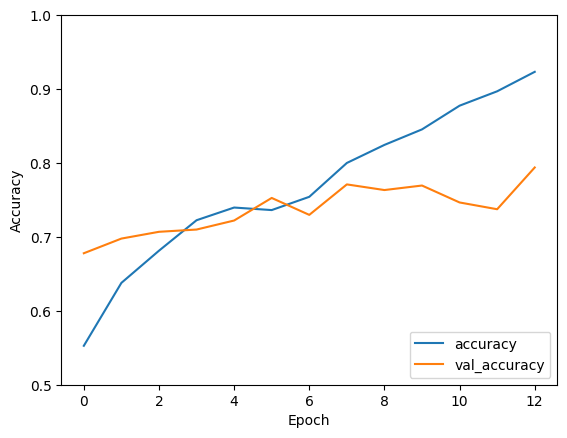

In [37]:
plt.plot(hist_no_dp.history['accuracy'], label='accuracy')
plt.plot(hist_no_dp.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model_no_dp.evaluate(X_test, y_test, verbose=2)

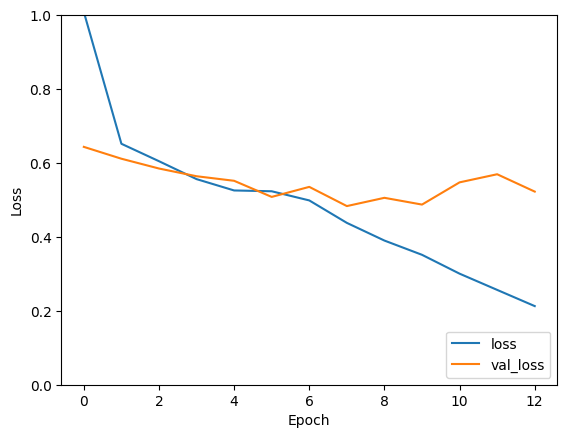

In [39]:
import numpy as np

plt.plot(hist_no_dp.history['loss'], label='loss')
plt.plot(hist_no_dp.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.xticks(np.arange(0, 14, 2))
plt.legend(loc='lower right')

# test_loss, test_acc = model_no_dp.evaluate(X_test, y_test, verbose=2)

In [42]:
y_predict=model_no_dp.predict(X_test)
y_predict[1]
# y_test[1]
# y_true=y_test
# res = tf.math.confusion_matrix(y_true,y_predict)

21/21 [==============================] - 1s 25ms/step


array([10.904766 ,  2.7948537], dtype=float32)